In [1]:
'''

In this exercise you will be presented with data from a fictional A/B test and asked to evaluate and interpret the results.

Carvana.com is testing a new feature and is running an A/B test to quantify the impact it has on different types of users. Before their first search, a user is bucketed into one of two treatment groups:
  Test - the user is exposed to the new feature
  Control - the user is not exposed to the new feature

All bucketed users can be found in the "users" dataframe/table. This data contains:
  user_id
  region
  treatment

All searches done by users can be found in the "searches" dataframe/table. This data contains:
  user_id
  event_date_time
  device_type
  event_id

As users progress through the website, their searches may return vehicles they are interested in. Clicking on a vehicle takes them to a vehicle detail page, or VDP. This is a strong sign of engagement.

All VDPs done by users can be found in the "vdps" dataframe/table. This data contains:
  user_id
  event_date_time
  device_type
  event_id

A user can purchase a vehicle driectly from a VDP. This constitues a sale and a conversion for the user.

All sales completed by users can be found in the "sales" dataframe/table. This data contains:
  user_id
  event_date_time
  device_type
  event_id

Use the four datasets described to accomplish the following tasks:

1) Evaluate the effect of the new feature on engagement (searches and VDPs) and conversion using statistical significance where applicable
2) Summarize and highlight insights (or issues) in user behavior across various segments
3) Provide a recommendation on whether or not to permanently deploy the feature to all users, some users, or no users

Clone or copy this notebook and run this cell to begin. Once you do so you will be able to work with the data in python and/or write sql queries against the data (see example cells below)

When submitting the assignment please provide a link to your notebook in addition to your typed respones to the items above in .pdf format.

The estimated time for this exercise is 3-4 hours. Please submit your answers to your recruiting coordinator. Good luck!

'''

################################
#### do not alter this code ####
################################

import pandas as pd

! pip install ipython-sql

users_path="https://s3-us-west-2.amazonaws.com/carvana-analytics-assignment/users.csv"
searches_path="https://s3-us-west-2.amazonaws.com/carvana-analytics-assignment/searches.csv"
vdps_path="https://s3-us-west-2.amazonaws.com/carvana-analytics-assignment/vdps.csv"
sales_path="https://s3-us-west-2.amazonaws.com/carvana-analytics-assignment/sales.csv"

users=pd.read_csv(users_path)
searches=pd.read_csv(searches_path)
vdps=pd.read_csv(vdps_path)
sales=pd.read_csv(sales_path)

%load_ext sql
%sql sqlite://

%sql persist users
%sql persist searches
%sql persist vdps
%sql persist sales

################################
#### do not alter this code ####
################################

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple
 * sqlite://
(sqlite3.OperationalError) near "persist": syntax error
[SQL: persist users]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
 * sqlite://
(sqlite3.OperationalError) near "persist": syntax error
[SQL: persist searches]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
 * sqlite://
(sqlite3.OperationalError) near "persist": syntax error
[SQL: persist vdps]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
 * sqlite://
(sqlite3.OperationalError) near "persist": syntax error
[SQL: persist sales]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


# Step 1:Data preprocessing

In [2]:
import pandas as pd

merged_data = pd.merge(users, searches, on='user_id', how='left')
merged_data = pd.merge(merged_data, vdps, on='user_id', how='left')
merged_data = pd.merge(merged_data, sales, on='user_id', how='left')

merged_data['event_id_x'] = merged_data['event_id_x'].notnull().astype(int)
merged_data['event_id_y'] = merged_data['event_id_y'].notnull().astype(int)
merged_data['event_id'] = merged_data['event_id'].notnull().astype(int)

test_group_data = merged_data[merged_data['treatment'] == 'Test']
control_group_data = merged_data[merged_data['treatment'] == 'Control']






### vdps required num

In [3]:
import statsmodels.stats.api as sms
vdps_test_rate = test_group_data['event_id_y'].sum() / test_group_data['event_id_y'].count()
vdps_control_rate = control_group_data['event_id_y'].sum() / control_group_data['event_id_y'].count()
effect_size = sms.proportion_effectsize(vdps_control_rate, vdps_test_rate)
required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
)
print("vdps required_n:", required_n)

vdps required_n: 37.751771943841455


In [4]:
import statsmodels.stats.api as sms
test_conversion_rate = test_group_data['event_id'].sum() / test_group_data['event_id_y'].sum()
control_conversion_rate = control_group_data['event_id'].sum() / control_group_data['event_id_y'].sum()
effect_size = sms.proportion_effectsize(test_conversion_rate, control_conversion_rate)
required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
)
print("conversion required_n:", required_n)

conversion required_n: 27.186381760112905


In [5]:
! pip install statsmodels


Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple


### VDPS significance test

In [6]:
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportion_confint, proportions_ztest

test_result = test_group_data['event_id_y'].sample(5000)
control_result = control_group_data['event_id_y'].sample(5000)
n_con = control_result.count()
n_test = test_result.count()
successes = [control_result.sum(), test_result.sum()]
nobs = [n_con, n_test]
t_stat, pval = proportions_ztest(successes, nobs=nobs,alternative='two-sided')
print(t_stat)
print(pval)



26.91525968847766
1.4558170976581962e-159


###  Conversion rate significance test

In [7]:
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportion_confint, proportions_ztest

test_conversion_group_data = test_group_data[test_group_data['event_id_y'] == 1]
control_conversion_group_data = control_group_data[control_group_data['event_id_y'] == 1]
test_result = test_conversion_group_data['event_id'].sample(5000)
control_result = control_conversion_group_data['event_id'].sample(5000)
n_con = control_result.count()
n_test = test_result.count()
successes = [control_result.sum(), test_result.sum()]
nobs = [n_con, n_test]
t_stat, pval = proportions_ztest(successes, nobs=nobs,alternative='two-sided')
print(t_stat)
print(pval)

-32.959738861518495
3.068112889112262e-238


### Regional dimension

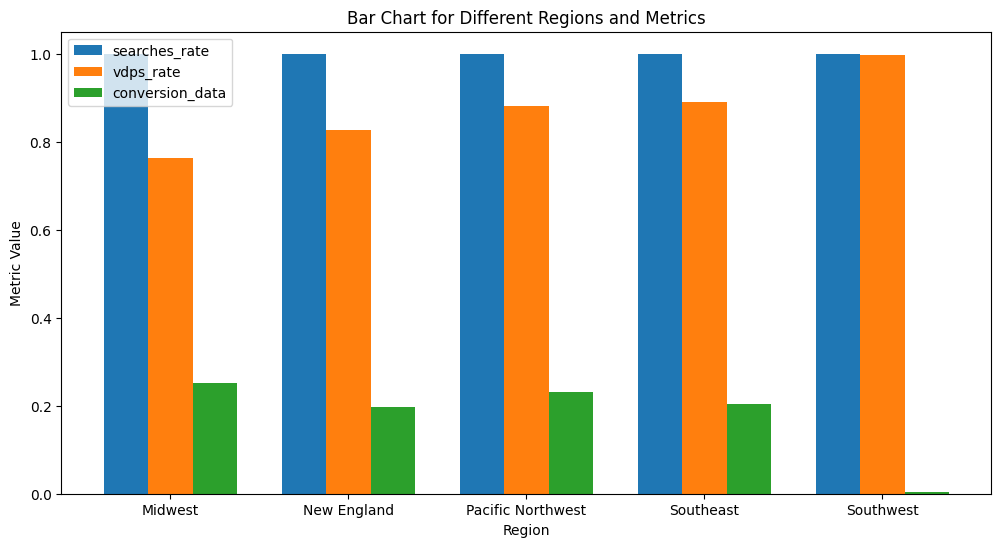

In [31]:
import matplotlib.pyplot as plt
import numpy as np

grouped_data = merged_data.groupby('region')

columns_to_compare = ['event_id_x', 'event_id_y', 'event_id']

plt.figure(figsize=(12, 6))

x = np.arange(len(grouped_data))
labels = []
for region, data in grouped_data:
    labels.append(region)

bar_width = 0.25
region_dict = {}
for region, data in grouped_data:
    searches_rate = 1
    vdps_rate = data['event_id_y'].sum() / data['event_id_y'].count()
    conversion_data = data['event_id'].sum() / data[data['event_id_y'] == 1]['event_id_y'].count()
    region_dict[region] = {
        'searches_rate': searches_rate,
        'vdps_rate': vdps_rate,
        'conversion_data': conversion_data
    }
first = []
second = []
third = []
for item in region_dict.items():
    first.append(item[1]['searches_rate'])
    second.append(item[1]['vdps_rate'])
    third.append(item[1]['conversion_data'])
plt.bar(x - bar_width, first, bar_width, label='searches_rate')
plt.bar(x, second, bar_width, label='vdps_rate')
plt.bar(x + bar_width, third, bar_width, label='conversion_data')
plt.xticks(x, labels)

plt.title('Bar Chart for Different Regions and Metrics')
plt.xlabel('Region')
plt.ylabel('Metric Value')

plt.legend()
plt.show()




### Device type dimension

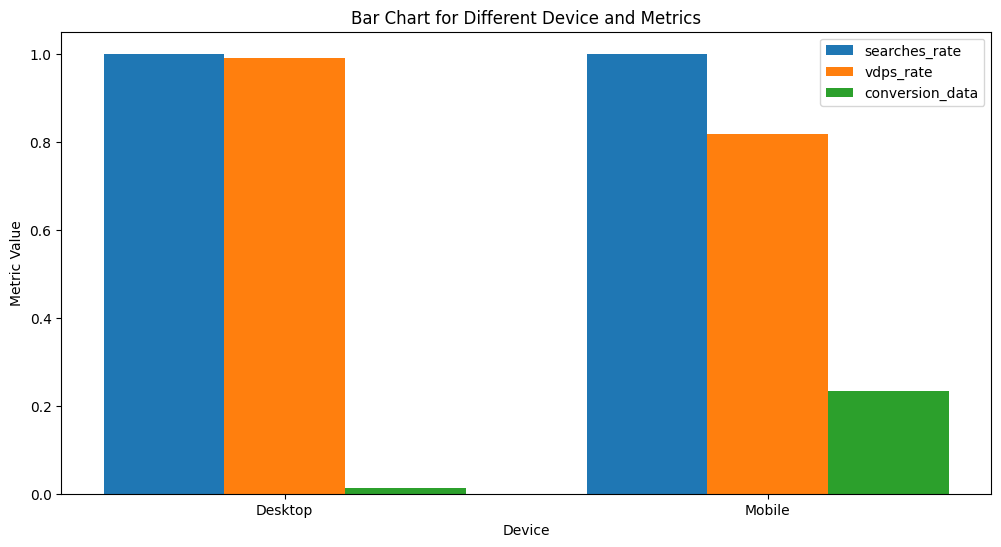

In [33]:
import matplotlib.pyplot as plt
import numpy as np

grouped_data = merged_data.groupby('device_type_x')

columns_to_compare = ['event_id_x', 'event_id_y', 'event_id']

plt.figure(figsize=(12, 6))

x = np.arange(len(grouped_data))
labels = []
for region, data in grouped_data:
    labels.append(region)

bar_width = 0.25
region_dict = {}
for region, data in grouped_data:
    searches_rate = 1
    vdps_rate = data['event_id_y'].sum() / data['event_id_y'].count()
    conversion_data = data['event_id'].sum() / data[data['event_id_y'] == 1]['event_id_y'].count()
    region_dict[region] = {
        'searches_rate': searches_rate,
        'vdps_rate': vdps_rate,
        'conversion_data': conversion_data
    }
first = []
second = []
third = []
for item in region_dict.items():
    first.append(item[1]['searches_rate'])
    second.append(item[1]['vdps_rate'])
    third.append(item[1]['conversion_data'])
plt.bar(x - bar_width, first, bar_width, label='searches_rate')
plt.bar(x, second, bar_width, label='vdps_rate')
plt.bar(x + bar_width, third, bar_width, label='conversion_data')
plt.xticks(x, labels)

plt.title('Bar Chart for Different Device and Metrics')
plt.xlabel('Device')
plt.ylabel('Metric Value')

plt.legend()
plt.show()

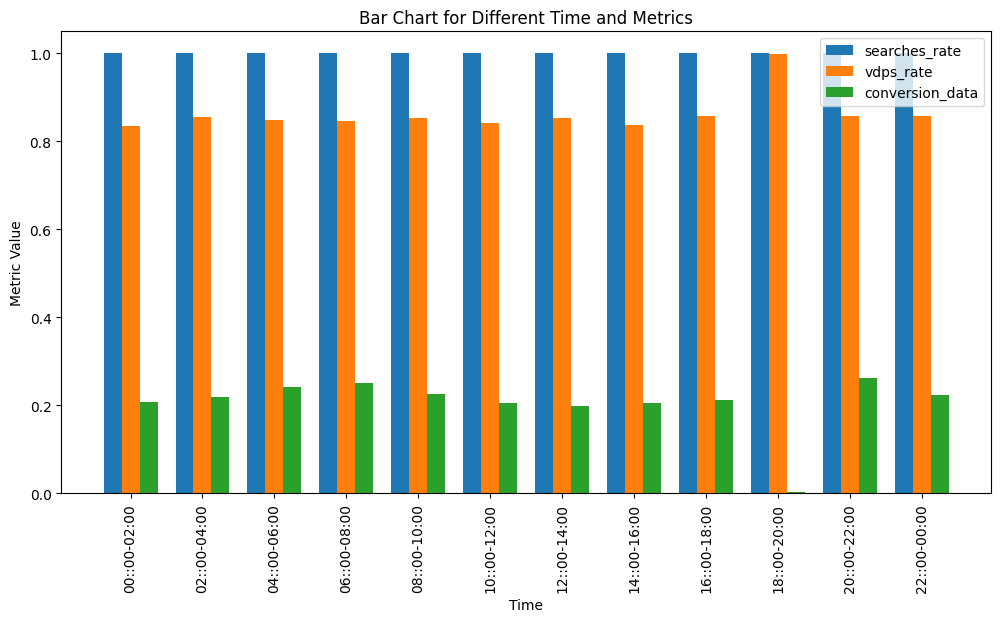

In [48]:
import matplotlib.pyplot as plt
import numpy as np


merged_data['event_date_time_x'] = pd.to_datetime(merged_data['event_date_time_x'], format='%Y-%m-%d %H:%M:%S')
merged_data['time_interval'] = pd.cut(merged_data['event_date_time_x'].dt.hour, bins=12, labels=False)
grouped_data = merged_data.groupby('time_interval')
columns_to_compare = ['event_id_x', 'event_id_y', 'event_id']

plt.figure(figsize=(12, 6))

x = np.arange(len(grouped_data))
labels = ["00::00-02:00",
          "02::00-04:00",
          "04::00-06:00",
          "06::00-08:00",
          "08::00-10:00",
          "10::00-12:00",
          "12::00-14:00",
          "14::00-16:00",
          "16::00-18:00",
          "18::00-20:00",
          "20::00-22:00",
          "22::00-00:00"]


bar_width = 0.25
region_dict = {}
for region, data in grouped_data:
    searches_rate = 1
    vdps_rate = data['event_id_y'].sum() / data['event_id_y'].count()
    conversion_data = data['event_id'].sum() / data[data['event_id_y'] == 1]['event_id_y'].count()
    region_dict[region] = {
        'searches_rate': searches_rate,
        'vdps_rate': vdps_rate,
        'conversion_data': conversion_data
    }
first = []
second = []
third = []
for item in region_dict.items():
    first.append(item[1]['searches_rate'])
    second.append(item[1]['vdps_rate'])
    third.append(item[1]['conversion_data'])
plt.bar(x - bar_width, first, bar_width, label='searches_rate')
plt.bar(x, second, bar_width, label='vdps_rate')
plt.bar(x + bar_width, third, bar_width, label='conversion_data')
plt.xticks(x, labels, rotation=90)

plt.title('Bar Chart for Different Time and Metrics')
plt.xlabel('Time')
plt.ylabel('Metric Value')

plt.legend()
plt.show()